## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Incorporation of temporal uncertainty Tutorial

When analyzing paleo environmental data, e.g., relative sea-level (RSL) records, it is important to consider the presence of uncertainties in both the reconstruction of RSL (vertical axis) and the chronology (horizontal axis) of the data. While it is relatively straightforward to incorporate output data uncertainty using variance-weighted Gaussian Process (GP) regression (i.e., adding vertical variance into the diagonal of covariance matrix), incorporating chronological uncertainties in GP regression is more challenging.

In this tutorial, we will demonstrate two commonly used methods for incorporating temporal uncertainty in paleo sea-level research:

**&#10148; 1.** Noisy-input Gaussian Process 

**&#10148; 2.** Errors-in-variable Gaussian Process 

Let's start with loading the module and generating some synthetic noisy data from a sine wave:

In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

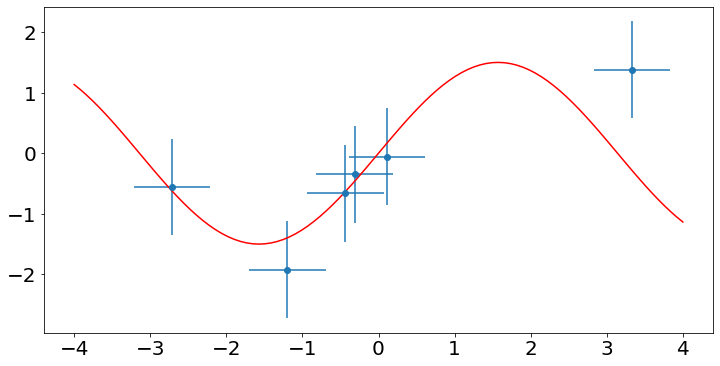

In [2]:
np.random.seed(12345)
x = torch.linspace(-3,3,100)[np.sort(np.random.randint(0,100,6))]
x_full = torch.linspace(-4,4,100)
def f(x):
    return 0+ 1.5*torch.sin(x)
y = f(x)

x_noise = 0.5
y_noise =0.8
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r');

You can clearly see that our data is very noisy and provide really limited information on the right side of the function. Let's start with normal GP only considering the vertical uncertainty:

In [5]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print('Length Scale: ',gpr.kernel.lengthscale.item(),'Variance: ',gpr.kernel.variance.item())
#cal misfit

GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


Length Scale:  1.6623892602457833 Variance:  0.45314039307398607


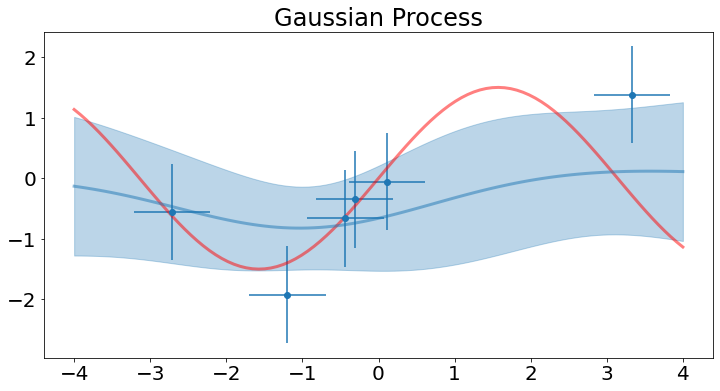

In [77]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')

Due to the significant uncertainties present in both the x and y axes of the data, the 95% credible interval (CI) obtained from normal Gaussian Process (GP) regression fails to accurately capture the true underlying function within the range between 0 and 2.5.

Now, let's explore the noisy-input GP (NIGP) method. The NIGP method employs a first-order Taylor series approximation, which involves a linear expansion around each input point. This approximation enables the translation of errors in the temporal domain into equivalent errors in the relative sea-level (RSL) domain. Consequently, temporal uncertainty is transformed into RSL uncertainty, which is proportional to the squared gradient of the GP posterior mean.

To implement the NIGP method, we can utilize the gradient of the posterior mean RSL estimation obtained from the normal GP method described earlier. This gradient is used to convert chronological errors into RSL errors, which are then incorporated as new errors for the subsequent GP regression analysis.

In [7]:
# NIGP method
pyro.clear_param_store()

 #-----------------Calculate RSL rate and transferring x error into y error-----------------
x_test = torch.tensor(x.clone().float(),requires_grad=True)
y_mean, y_var = gpr(x_test, full_cov=False)
y_mean.sum().backward(retain_graph=True)
y_rate = x_test.grad.detach().numpy()
new_sigma = np.sqrt(y_rate**2*x_noise**2+y_noise**2)

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
NI_gpr = NI_gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(NI_gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(NI_gpr.model, NI_gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print('Length Scale: ',NI_gpr.kernel.lengthscale.item(),'Variance: ',NI_gpr.kernel.variance.item())


NIGP_matrix = NI_RBF_kernel(x_full,x)@ torch.linalg.inv(NI_RBF_kernel(x,x) + torch.eye(len(x))*y_noise**2 + torch.eye(len(x))*x_noise**2*y_rate**2)
NIGP_mean = NIGP_matrix @y
NIGP_var = NI_RBF_kernel(x_full,x_full) - NIGP_matrix @ NI_RBF_kernel(x,x_full)
NIGP_sd = torch.diag(NIGP_var).sqrt()

Length Scale:  1.6622852386982374 Variance:  0.4561355639277197


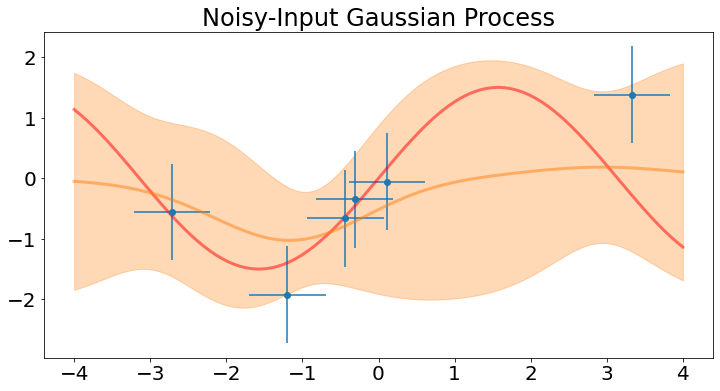

In [76]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')


Upon incorporating information about chronological errors, the 95% credible interval (CI) obtained through the noisy-input Gaussian Process (NI-GP) method exhibits a significant improvement, demonstrating a more reasonable behavior when dealing with the noisy data. Notably, the 95% CI successfully captures the true underlying function across the entire range.

Another approach to address temporal uncertainty is by directly sampling temporal uncertainty using the errors-in-variable framework through the utilization of the Markov Chain Monte Carlo (MCMC) algorithm, which enables a Fully Bayesian Analysis. It is important to note that specifying the prior distribution is crucial in the Fully Bayesian Analysis as it directly impacts the prediction results. Considering the data and Empirical Bayes results, here I select a uniform prior distribution ranging from 0 to 6 for the length scale and from 0 to 20 for the variance.

In [125]:
# EIV-GP method
from pyro.infer import MCMC, NUTS, HMC
from pyro.contrib.gp.util import conditional

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(20.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1e-3), torch.tensor(6.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.GPRegression_EIV(x, y, x_noise**2,RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
EIV_gpr = EIV_gpr.double()

#generate NUTS sampler 
hmc_kernel = NUTS(EIV_gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1000,warmup_steps=200)
mcmc.run()
mean_lengthscale = mcmc.get_samples()['kernel.lengthscale'].mean()
mean_variance = mcmc.get_samples()['kernel.variance'].mean()
print('Length Scale: ',mean_lengthscale.item(),'Variance: ',mean_variance.item())


Sample: 100%|██████████| 1200/1200 [00:24, 49.52it/s, step size=7.99e-01, acc. prob=0.844]

Length Scale:  3.4558753967285156 Variance:  5.121336936950684


In [126]:
thin_variance = mcmc.get_samples()['kernel.variance']
thin_lengthscale = mcmc.get_samples()['kernel.lengthscale']

from pyro.contrib.gp.util import conditional
EIV_gpr.set_mode("guide")
X_new = x_full
N = EIV_gpr.X.size(0)
N_new = X_new.size(0)
y_residual = EIV_gpr.y - EIV_gpr.mean_function(EIV_gpr.X)
likelihood_list = []
full_bayes_mean,full_bayes_cov = torch.zeros(N_new),torch.zeros(N_new,N_new)
for i in range(len(thin_lengthscale)):
    EIV_gpr.kernel.lengthscale = thin_lengthscale[i]
    EIV_gpr.kernel.vairance = thin_variance[i]
    Kff = EIV_gpr.kernel(EIV_gpr.X).contiguous()
    Kff.view(-1)[:: N + 1] += EIV_gpr.jitter + EIV_gpr.noise  # add noise to the diagonal
    Lff = torch.linalg.cholesky(Kff)
    loc, cov = conditional(
        X_new,
        EIV_gpr.X,
        EIV_gpr.kernel,
        y_residual,
        None,
        Lff,
        True,
        jitter=EIV_gpr.jitter,
    )
    full_bayes_mean +=loc
    full_bayes_cov+=cov
    f_pred = interpolate.interp1d(X_new.detach().numpy(),loc.detach().numpy())
    rsl_pred = f_pred(EIV_gpr.X.detach().numpy())
    likelihood_list.append(PSTHM.cal_likelihood(EIV_gpr.y.detach().numpy(),torch.ones(N)*y_noise,rsl_pred))

full_bayes_mean/=len(thin_lengthscale)
full_bayes_cov/=len(thin_lengthscale)
EIVGP_mean = full_bayes_mean
EIVGP_sd = torch.diag(full_bayes_cov).sqrt()  # standard deviation at each input point x


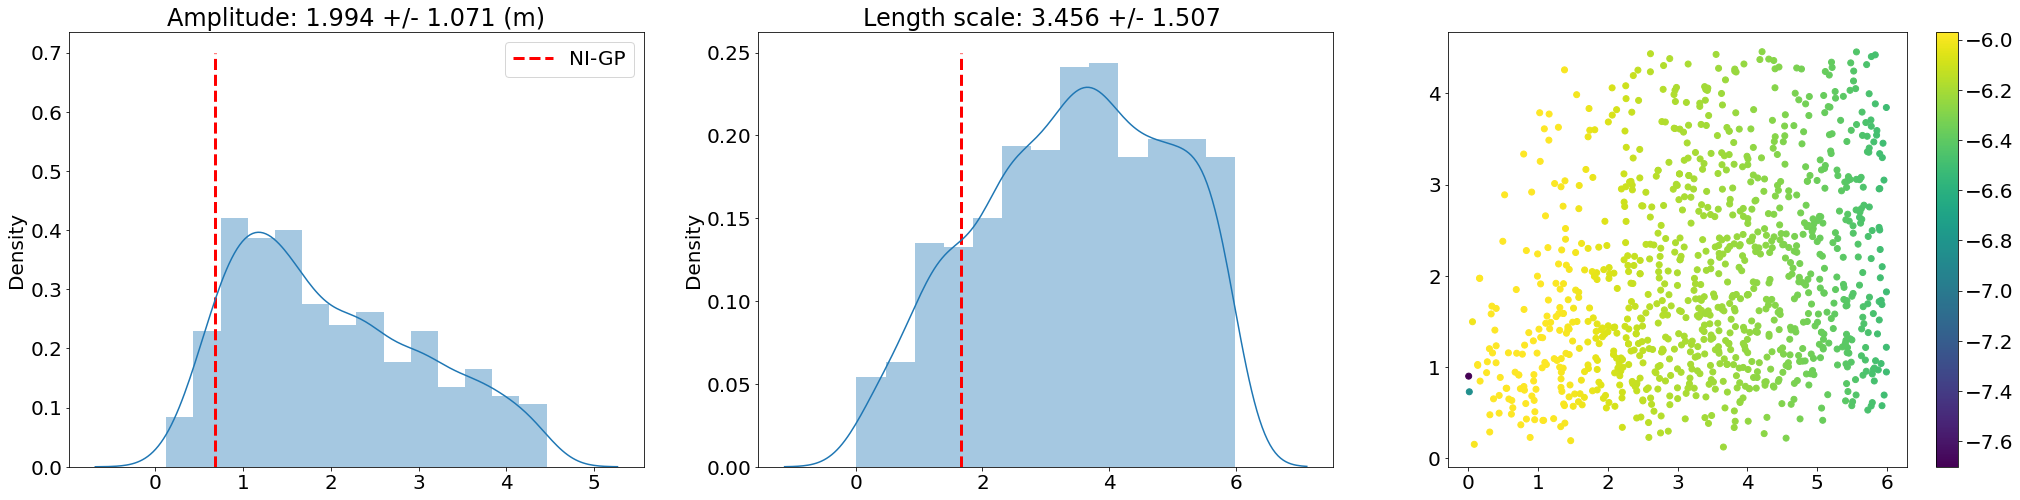

In [127]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.title('Likelihood')

plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.colorbar();

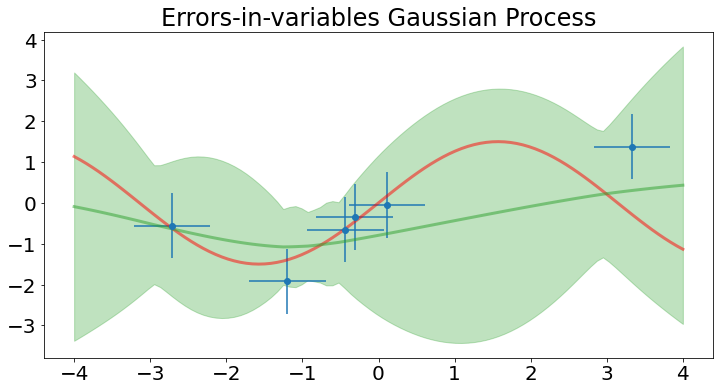

In [128]:
plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI');



Upon examining the results, it becomes evident that the 95% CI obtained through the Errors-in-Variable Gaussian Process (EIV-GP) method exhibits a more structured behavior compared to the Noisy-Input GP (NI-GP) method. This improved structure is a result of directly sampling the x errors using the MCMC algorithm within the EIV-GP framework. Like NI-GP, the 95% CI derived from the EIV-GP method accurately captures the true underlying function.

Now, let's compare and visualize the outcomes of the three different methods by plotting them together for a comprehensive evaluation.

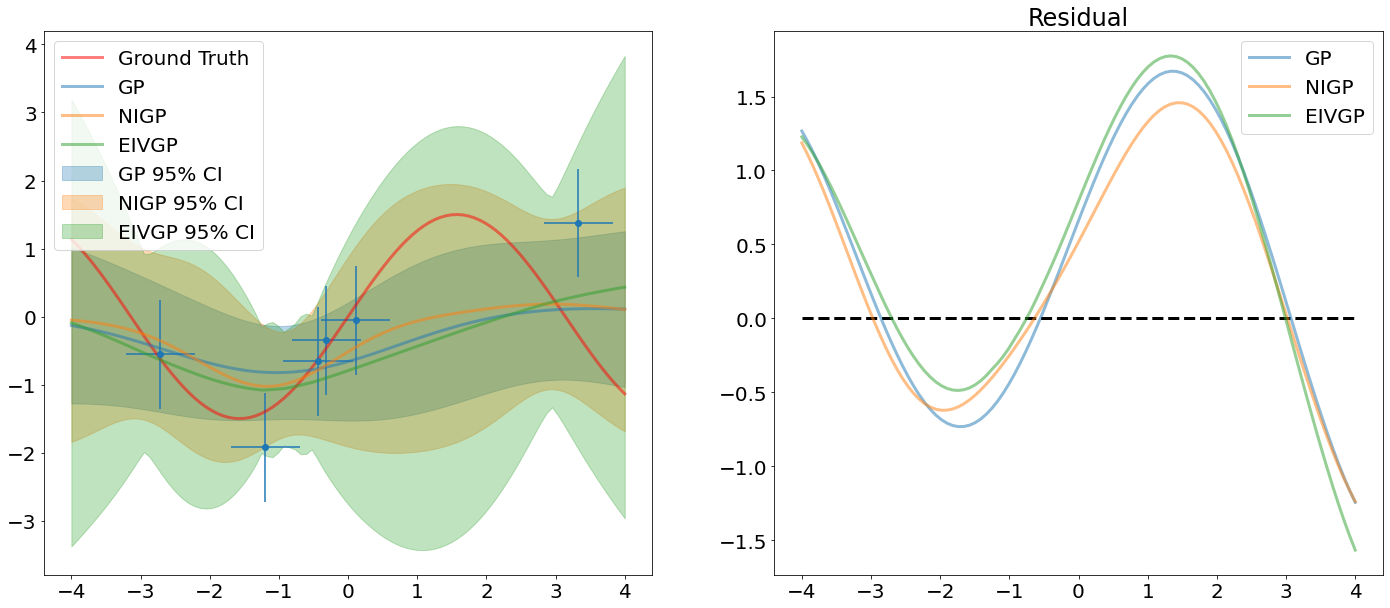

In [130]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

You might find the regression results aren't satisfying at all! But given the really noisy data and limited data amount, GPs actually already do a fairly good job. This unsatisfactory results can be easily improved by slight increase the data amount and less observational uncertainty, let's try to generate some new data with slightly more observation data (10 vs 6) with lower observational uncertainty (0.4 vs 0.6). 

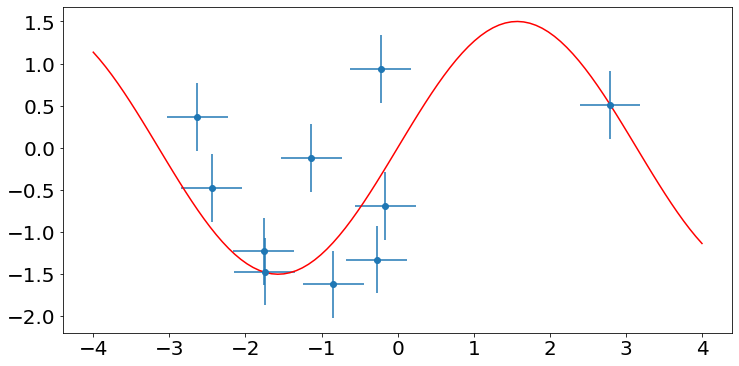

In [150]:
np.random.seed(12345)
x = torch.linspace(-3,3,100)[np.sort(np.random.randint(0,100,10))]
x_full = torch.linspace(-4,4,100)
def f(x):
    return 0+ 1.5*torch.sin(x)
y = f(x)

x_noise = 0.4
y_noise =0.4
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r');

You can see that the observational data still looks quite confusing, let's see how different GPs recovery the true function!

In [151]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print('Length Scale: ',gpr.kernel.lengthscale.item(),'Variance: ',gpr.kernel.variance.item())
#cal misfit

GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


Length Scale:  1.13367071707922 Variance:  0.7016391099042683


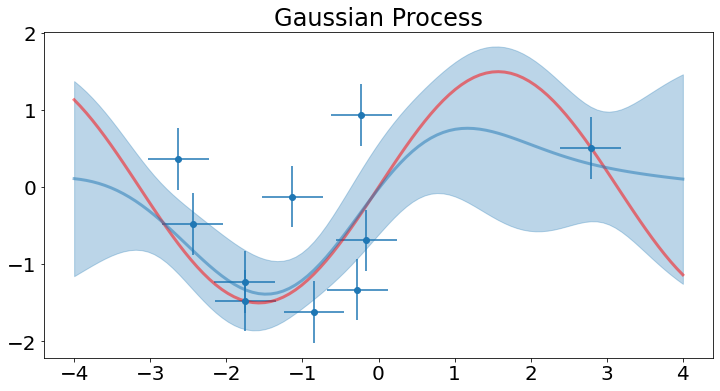

In [152]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')

In [153]:
# NIGP method
pyro.clear_param_store()

 #-----------------Calculate RSL rate and transferring x error into y error-----------------
x_test = torch.tensor(x.clone().float(),requires_grad=True)
y_mean, y_var = gpr(x_test, full_cov=False)
y_mean.sum().backward(retain_graph=True)
y_rate = x_test.grad.detach().numpy()
new_sigma = np.sqrt(y_rate**2*x_noise**2+y_noise**2)

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
NI_gpr = NI_gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(NI_gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(NI_gpr.model, NI_gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print('Length Scale: ',NI_gpr.kernel.lengthscale.item(),'Variance: ',NI_gpr.kernel.variance.item())


NIGP_matrix = NI_RBF_kernel(x_full,x)@ torch.linalg.inv(NI_RBF_kernel(x,x) + torch.eye(len(x))*y_noise**2 + torch.eye(len(x))*x_noise**2*y_rate**2)
NIGP_mean = NIGP_matrix @y
NIGP_var = NI_RBF_kernel(x_full,x_full) - NIGP_matrix @ NI_RBF_kernel(x,x_full)
NIGP_sd = torch.diag(NIGP_var).sqrt()

Length Scale:  1.080640535065069 Variance:  0.6571558269437779


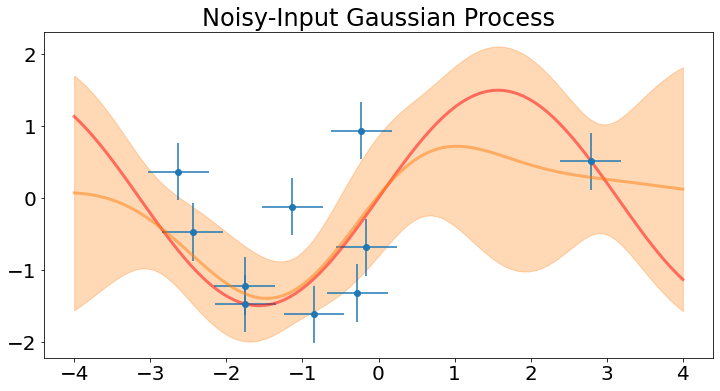

In [154]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')


In [155]:
# EIV-GP method
from pyro.infer import MCMC, NUTS, HMC
from pyro.contrib.gp.util import conditional

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(20.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1e-3), torch.tensor(6.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.GPRegression_EIV(x, y, x_noise**2,RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
EIV_gpr = EIV_gpr.double()

#generate NUTS sampler 
hmc_kernel = NUTS(EIV_gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1000,warmup_steps=200)
mcmc.run()
mean_lengthscale = mcmc.get_samples()['kernel.lengthscale'].mean()
mean_variance = mcmc.get_samples()['kernel.variance'].mean()
print('Length Scale: ',mean_lengthscale.item(),'Variance: ',mean_variance.item())


Sample: 100%|██████████| 1200/1200 [00:39, 30.69it/s, step size=4.53e-01, acc. prob=0.923]

Length Scale:  1.9034724235534668 Variance:  4.976900577545166


In [156]:
thin_variance = mcmc.get_samples()['kernel.variance']
thin_lengthscale = mcmc.get_samples()['kernel.lengthscale']

from pyro.contrib.gp.util import conditional
EIV_gpr.set_mode("guide")
X_new = x_full
N = EIV_gpr.X.size(0)
N_new = X_new.size(0)
y_residual = EIV_gpr.y - EIV_gpr.mean_function(EIV_gpr.X)
likelihood_list = []
full_bayes_mean,full_bayes_cov = torch.zeros(N_new),torch.zeros(N_new,N_new)
for i in range(len(thin_lengthscale)):
    EIV_gpr.kernel.lengthscale = thin_lengthscale[i]
    EIV_gpr.kernel.vairance = thin_variance[i]
    Kff = EIV_gpr.kernel(EIV_gpr.X).contiguous()
    Kff.view(-1)[:: N + 1] += EIV_gpr.jitter + EIV_gpr.noise  # add noise to the diagonal
    Lff = torch.linalg.cholesky(Kff)
    loc, cov = conditional(
        X_new,
        EIV_gpr.X,
        EIV_gpr.kernel,
        y_residual,
        None,
        Lff,
        True,
        jitter=EIV_gpr.jitter,
    )
    full_bayes_mean +=loc
    full_bayes_cov+=cov
    f_pred = interpolate.interp1d(X_new.detach().numpy(),loc.detach().numpy())
    rsl_pred = f_pred(EIV_gpr.X.detach().numpy())
    likelihood_list.append(PSTHM.cal_likelihood(EIV_gpr.y.detach().numpy(),torch.ones(N)*y_noise,rsl_pred))

full_bayes_mean/=len(thin_lengthscale)
full_bayes_cov/=len(thin_lengthscale)
EIVGP_mean = full_bayes_mean
EIVGP_sd = torch.diag(full_bayes_cov).sqrt()  # standard deviation at each input point x


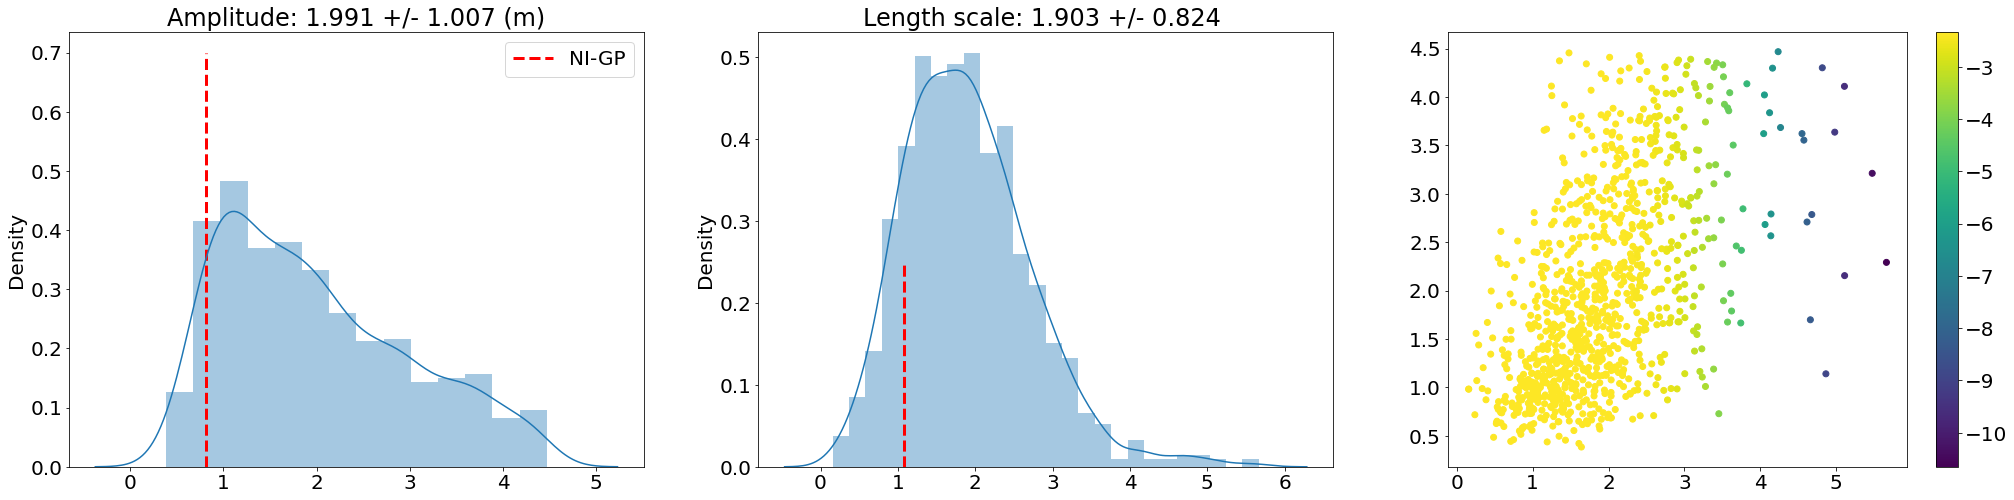

In [157]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.title('Likelihood')
plt.colorbar();

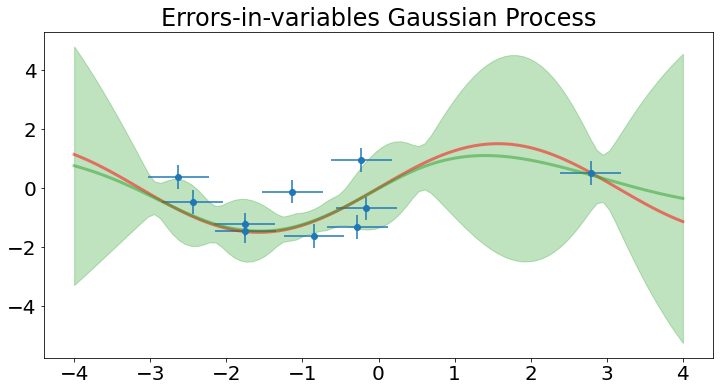

In [158]:
plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI');



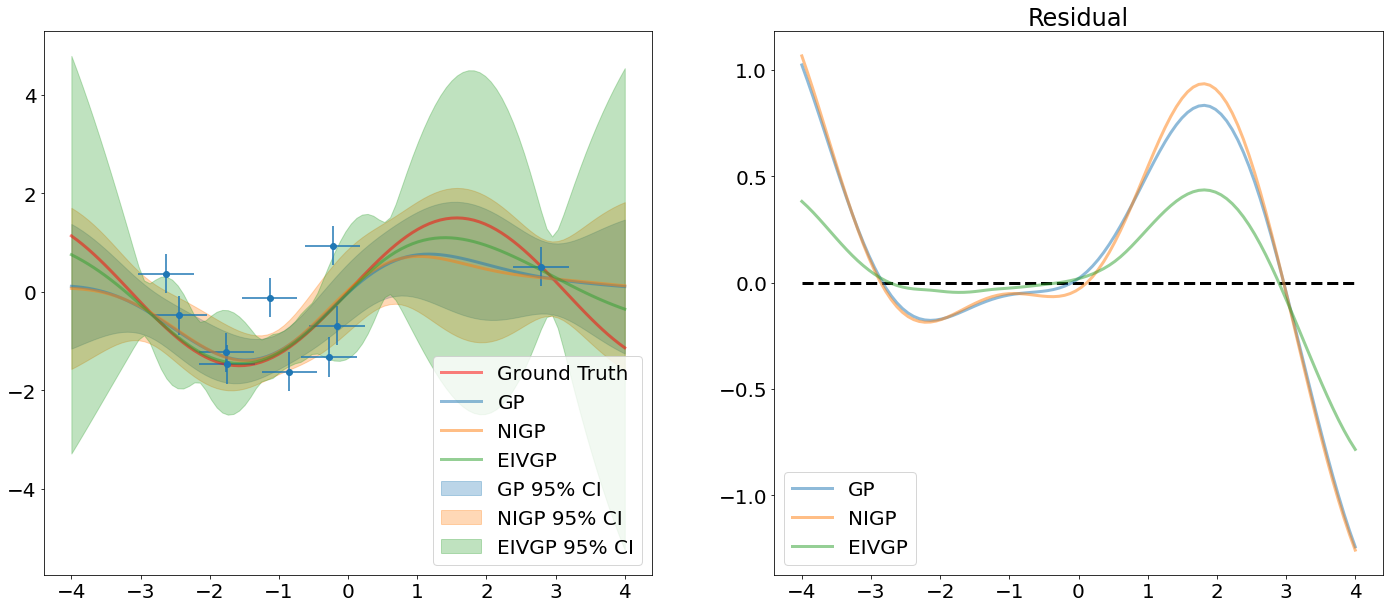

In [159]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

Even observations are still very noisy, three GPs did a great job in recoverying the truth signal! The EIV-GP method seems to show the best performance here. But for more complicated problem, EIV-GP may be very computationally expensive, in that case NIGP can be a good substitute. 